In [1]:
# get_ipython().magic('matplotlib notebook')
get_ipython().magic('matplotlib inline')
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import shapefile as shp
import numpy as np

In [2]:
# Parameters
mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 3
which_mode= 'xmoc'

#_____________________________________________________________________________________
input_paths= list()
# input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.3/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/')
input_paths.append('/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.3/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.3/')
input_paths.append('/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.3/')

input_names= list()
# input_names.append('TKE, ck=0.1')
input_names.append('TKE, ck=0.3')
input_names.append('TKE+IDEMIX, ck=0.1, jayne (old param)')
input_names.append('TKE+IDEMIX, ck=0.1, jayne (new param)')
input_names.append('TKE+IDEMIX, ck=0.1, nycander (new param)')
input_names.append('TKE+IDEMIX, ck=0.1, stormtide (new param)')
input_names.append('TKE+IDEMIX, ck=0.3, jayne (new param)')
input_names.append('TKE+IDEMIX, ck=0.3, nycander (new param)')
input_names.append('TKE+IDEMIX, ck=0.3, stormtide (new param)')

vname     = 'amoc'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None # 'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr      = 'blue2red'
cnum      = 20
cref      = 0
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
ncolumn   = 3 
do_rescale= True
which_dpi = 300
do_contour= True

In [3]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)        
        
#______________________________________________________________________________________________________        
cinfo=dict({'cstr':cstr, 'cnum':cnum}) 
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac   
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    

 > found *.pckl file: /work/ollie/pscholz/meshcache_tripyview/core2
 > load  *.pckl file: tripyview_fesom2_core2.pckl
___FESOM2 MESH INFO________________________
 > path            = /work/ollie/projects/clidyn/FESOM2/meshes/core2
 > id              = core2
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________
0 /home/ollie/pscholz/results/trr181_tke_ctrl_ck0.3/3/
1 /home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/3/
2 /home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/3/
3 /home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/3/
4 /home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/3/
5 /home/ollie/pscholz/results/trr181_tke+idemi

In [4]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'

#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=aux_vname, year=ref_year, descript=ref_name , do_info=False) 
    data_ref[aux_vname].data = data_ref[aux_vname].data+tpv.load_data_fesom2(mesh, ref_path, vname=aux_vnamebv, year=ref_year, do_info=False)[aux_vnamebv].data

#___LOAD FESOM2 DATA___________________________________________________________________________________    
data_list = list()
for datapath, descript in zip(input_paths, input_names): 
    print(datapath, descript)
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript , do_info=False) 
    data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year, do_info=False)[aux_vnamebv].data
    data_list.append(data)
    del(data)

#___COMPUTE XMOC_______________________________________________________________________________________
if ref_path is not None:
    moc_ref = tpv.calc_xmoc(mesh, data_ref, dlat=1.0, which_moc=vname, do_info=False)
    del(data_ref)

moc_list = list()
for data in data_list:
    moc = tpv.calc_xmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False)
    if ref_path is not None: moc_list.append( tpv.do_anomaly(moc, moc_ref) )
    else:                    moc_list.append( moc )
del(data_list, data, moc)        

/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.3/3/ TKE, ck=0.3
/home/ollie/pscholz/results/trr181_tke+idemix_orig_ck0.1/3/ TKE+IDEMIX, ck=0.1, jayne (old param)
/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.1/3/ TKE+IDEMIX, ck=0.1, jayne (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.1/3/ TKE+IDEMIX, ck=0.1, nycander (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.1/3/ TKE+IDEMIX, ck=0.1, stormtide (new param)
/home/ollie/pscholz/results/trr181_tke+idemix_jayne09_ck0.3/3/ TKE+IDEMIX, ck=0.3, jayne (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_nycander05_ck0.3/3/ TKE+IDEMIX, ck=0.3, nycander (new param)
/home/ollie/pscholz/results/old_trr181_tke+idemix_stormtide2_ck0.3/3/ TKE+IDEMIX, ck=0.3, stormtide (new param)


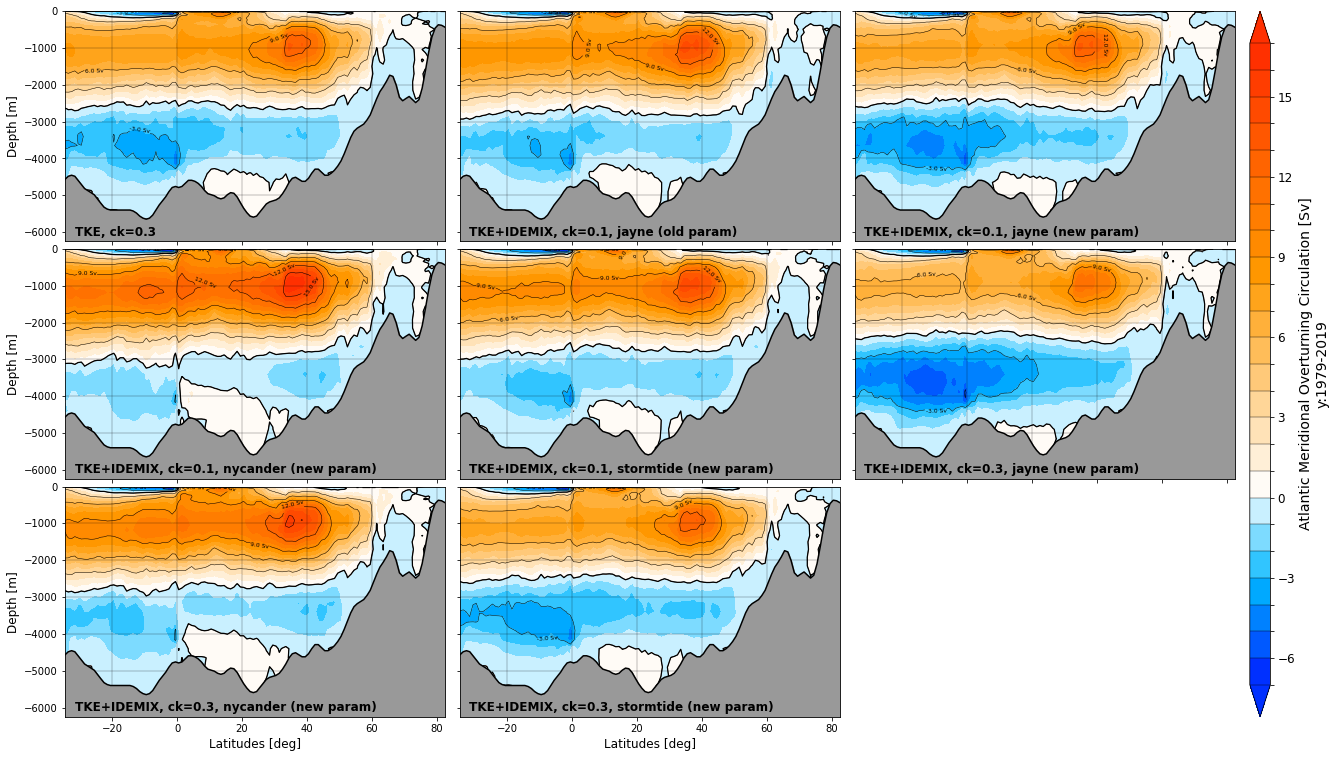

In [5]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
sname  = vname
slabel = moc_list[0]['moc'].attrs['str_lsave']
if spath is not None: spath  = os.path.join(spath,'{}_{}_{}.png'.format(which_mode, sname, slabel)) 
nrow   = np.ceil(len(moc_list)/ncolumn).astype('int')
if save_fname is not None: spath = save_fname
#____________________________________________________________________________________________________
fig, ax, cbar=tpv.plot_xmoc(moc_list, which_moc=vname, cinfo=cinfo, figsize=[ncolumn*7, nrow*3.5], n_rc=[nrow, ncolumn], 
              do_save = spath, save_dpi=which_dpi, do_contour = do_contour)
